<font size="5.5"><u><i>General Relativistic Waveforms Explorer</i></u></font>

<font size="4">Exploratory analysis and filtering of core-collapse supernova (CCSN) general relativistic gravitational wave signals.</font>
<br/>
<font size="4">Author: Manuel David Morales</font>

## 0. Preliminaries

### 0.1. Library imports

In [7]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import colors

# Files/folders management
import h5py
import os, glob, sys, re, io

# Scientific computing
from scipy import signal
from scipy import stats
import statistics

# Garbage collector
import gc

# Image management
from PIL import Image

# Toolbox functions
from Toolbox import extract_WFinfo, rescale_gw, resample_gw, remove_gw_edges, SNR, SNR_PyCBC, WaveletTF_transform, Morlet_wavelet, check_class_HFFslope, filt_highpass_NumWF

### 0.2. Input parameters

In [10]:
# Distance from the emitting source (in Kpc)
# ------------------------------------------------------------
set_distance = 10   
# ------------------------------------------------------------

# Frequency to resample waveforms (in Hz)
# ------------------------------------------------------------
fs_after = 4096
# ------------------------------------------------------------

### 0.3. Other settings

In [13]:
# Local path for CCSNe numerical waveforms
wf_num_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/datagen-sngw-genrel/Waveforms_orig/GenRel/'

# constants to convert centimeters 
cm2kpc  = 3.24078e-22
D10kpc  = cm2kpc / 10 # 10 kpc

## 1. Andresen 2019 3D models

### 1.1. Read files

In [17]:
# ------> Remarks

# Paper available on: https://doi.org/10.1093/mnras/stz990 [arXiv:1810.07638]
# Waveforms available on: https://wwwmpa.mpa-garching.mpg.de/ccsnarchive/data/Andresen2019/

# ------> Set model's name

model_name = "Andresen 2019 m15nr h+"

# ------> Read files

# Read dat file
file_path = wf_num_dir + "Andresen 2019/" + "s15_nr_gw_equ.dat"
wf_model = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Select polarization
wf_model = wf_model.iloc[:, [0, 2]]

# Name columns
wf_model.columns = ['Time (s)', 'h+ (cm)']

# Check: Print dataframe
print(model_name)
print("----------------------------------")
print(wf_model.head())

Andresen 2019 m15nr h+
----------------------------------
   Time (s)   h+ (cm)
0  0.009950 -0.229169
1  0.010453 -0.163051
2  0.010953 -0.957762
3  0.011456  0.588487
4  0.011957 -0.114333


### 1.2. Resample waveform

In [20]:
# ------> Create numpy arrays

waveform = wf_model.to_numpy()
wf_model = np.transpose(waveform)

# ------> Resampling to fs = fs_after

t, s_hp = resample_gw(wf_model[0], wf_model[1], fs_after)

### 1.3. Rescale waveform

In [23]:
# ------> Convert strains to adimensional at 10 Kpc 

s_hp = s_hp * D10kpc

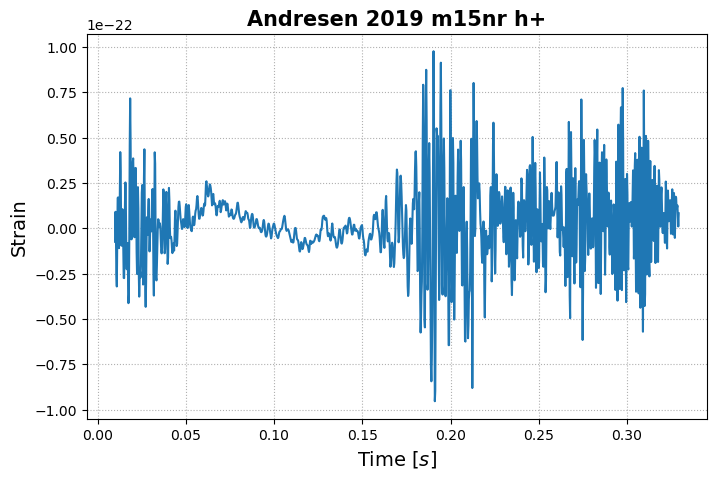

5628

<Figure size 640x480 with 0 Axes>

In [25]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t, s_hp)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

#plt.savefig("../Figures/" + "Andresen_strain.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

In [27]:
# ------> Set some distances to check strain plots

s_hp_5  = rescale_gw(s_hp, 5)
s_hp_20 = rescale_gw(s_hp, 20)
s_hp_40 = rescale_gw(s_hp, 40)

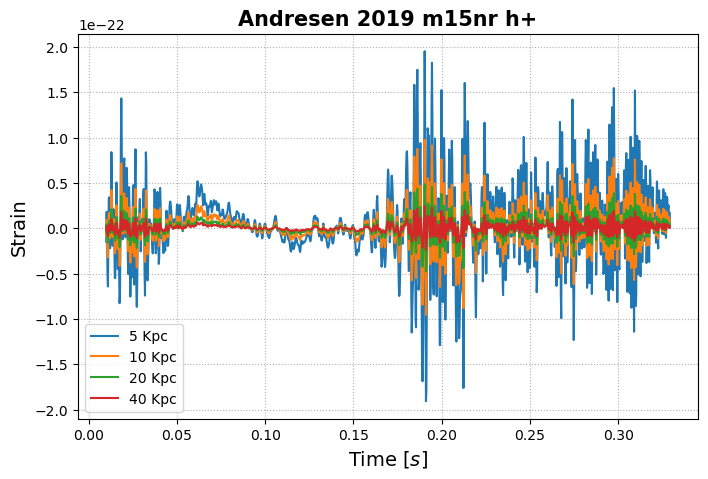

4867

<Figure size 640x480 with 0 Axes>

In [29]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

plt.plot(t, s_hp_5, label="5 Kpc")
plt.plot(t, s_hp, label="10 Kpc")
plt.plot(t, s_hp_20, label="20 Kpc")
plt.plot(t, s_hp_40, label="40 Kpc")
plt.legend()

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

### 1.4. Generate scalogram

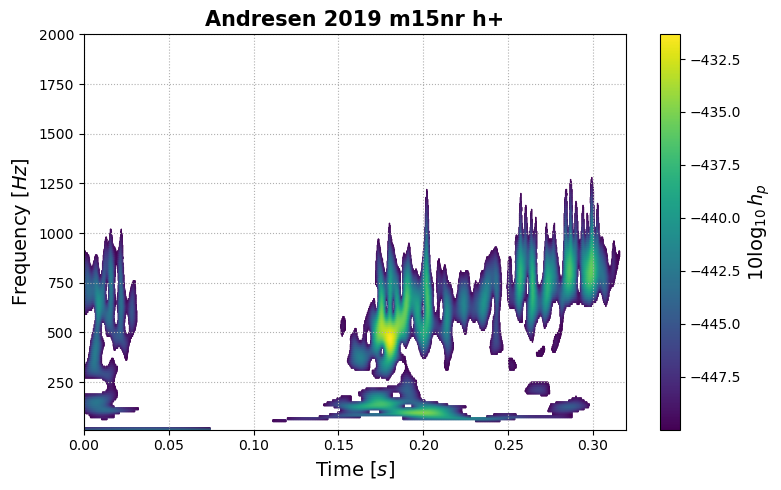

7657

<Figure size 640x480 with 0 Axes>

In [32]:
# ------> Compute wavelet transform

#time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 1000, 10, 7, 0) # Only for printable plot
time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 2000, 10, 7, 0)

# ------> Plot scalogram

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

# ------- LOG_10 SCALE

log_WL = 10 * np.log10(WL)

# Set threshold for pixels
############################################
threshold = -450
############################################

# Apply the threshold to the spectrogram data
log_WL_thr = np.where(log_WL > threshold, log_WL, np.nan)

plt.pcolormesh(time, freq, log_WL_thr, shading='gouraud')
plt.colorbar().set_label(label="$10\log_{10} h_p$", size=14)

# ------- LINEAR SCALE

#plt.pcolormesh(time, freq, WL, shading='gouraud')

#norm = colors.Normalize(s_hp.min(), s_hp.max())
#mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

#plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

# -------------------------

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Andresen_scalogram.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

### 1.5. HFF slope estimation

Wavelet Matrix dim: (200, 1309)
Time array dim: (1309,)
Frequency array dim: (200,)

Delta t =  0.000244140625
Delta f =  10.0

Aritmetic mean of WL pixels: 9.160918371871166e-46

Sorted t array length: 25724
Sorted f array length: 25724
Sorted W array length: 25724



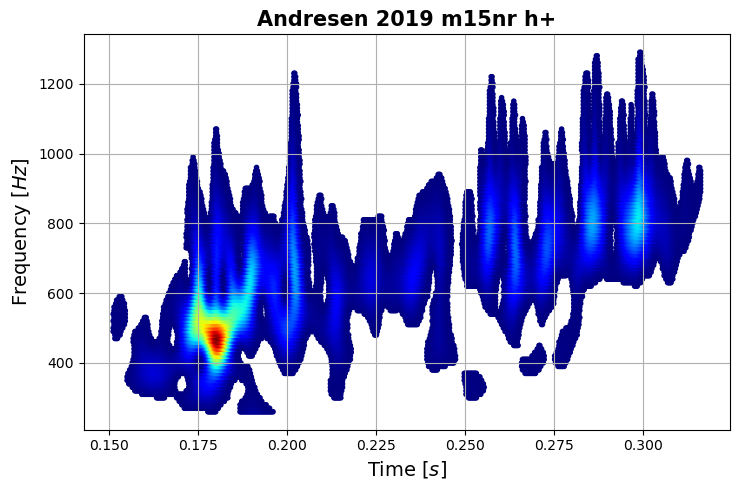

In [35]:
# ------> Plot pixelized (scattered) scalogram

# Check dimensions
print("Wavelet Matrix dim:", WL.shape)
print("Time array dim:", time.shape)
print("Frequency array dim:", np.transpose(freq)[0].shape)

print("")

# Sampling time / frequency
delta_t = time[1] - time[0]
delta_f = freq[1][0] - freq[0][0]
print("Delta t = ", delta_t)
print("Delta f = ", delta_f)

print("")

# Mean of WL pixels
WL_mean = np.mean(WL)
print("Aritmetic mean of WL pixels:", WL_mean)

# Reorganize arrays for time, freq, and wavelet

sorted_t = []
sorted_f = []
sorted_W = []

# Remark: WL[freq_index][time_index] (elements)
#         freq_index for row, time_index is for column

for freq_index in range(WL.shape[0]):    
    for time_index in range(WL.shape[1]):
        
        # Selection 1: Most energetic pixels,
        #              WL > mean(WL)
        if WL[freq_index][time_index] > WL_mean:
            
            # Selection 2: Pixels non in convection feature
            #              t > 0.1 seconds
            if time_index*delta_t > 0.1:
            
            # Selection 3: Pixels non in SASI feature,
            #              f > 250 Hz
                if (freq_index+1)*delta_f > 250:
                
                    sorted_t.append(time[time_index])
                    sorted_f.append(freq[freq_index])
                    sorted_W.append(WL[freq_index][time_index])

print("")
            
# Check dimensions
print("Sorted t array length:", len(sorted_t))
print("Sorted f array length:", len(sorted_f))
print("Sorted W array length:", len(sorted_W))

print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)

plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")

#norm = colors.Normalize(s_hp.min(), s_hp.max())
#mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)
#plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()
plt.show()

Linear regression for most energetic pixels
---------------------------------------------
R-squared: 0.7890585362978463
Intercept: 36.49849445200198
Slope: 2601.994603038078
---------------------------------------------



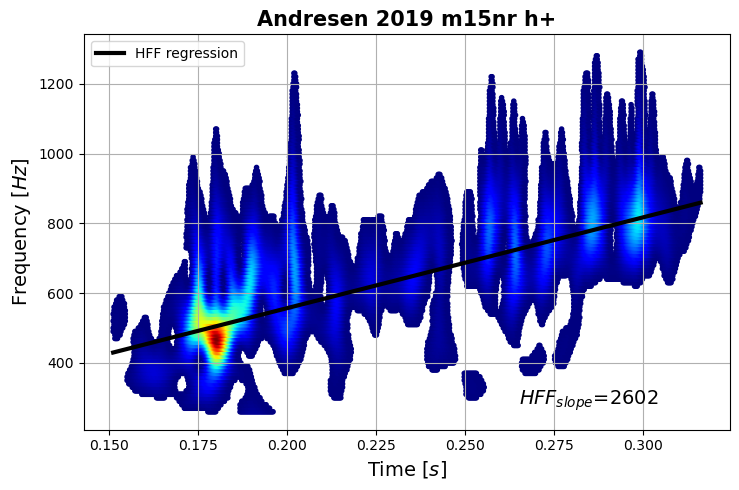

<Figure size 640x480 with 0 Axes>

In [37]:
# ------> Linear regression to estimate HFF slope

# Unique values of time
unique_t = np.unique(sorted_t)

# Initialize array for location of
# most energetic pixels per time
locate_maxpix = []

# Select most energetic pixels per time
for i in range(len(unique_t)):
    
    # Find location indexes for unique_t(i) in sorted_t array
    time_loc_ind = np.where(sorted_t == unique_t[i])[0]

    # Select most energetic pixel at time unique_t(i)
    W_max = 0
    for j in range(len(time_loc_ind)):
        
        if sorted_W[time_loc_ind[j]] > W_max:
            W_max = sorted_W[time_loc_ind[j]]
            ind_max_onetime = time_loc_ind[j]
    
    locate_maxpix.append(ind_max_onetime)

# Location (time,freq) of most energetic pixels
t_lr = np.take(sorted_t, locate_maxpix)
f_lr = np.take(sorted_f, locate_maxpix)

# Apply linear regression
res = stats.linregress(t_lr, f_lr)

# Print results
print("Linear regression for most energetic pixels")
print("---------------------------------------------")
print("R-squared:", res.rvalue**2)
print("Intercept:", res.intercept)
print("Slope:", res.slope)
print("---------------------------------------------")
print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)
plt.plot(t_lr, res.intercept + res.slope*t_lr, 'k-', linewidth=3, label='HFF regression')
plt.text(0.265, 280,'$HFF_{slope}$='+str(round(res.slope)), fontsize=14)

plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")
plt.legend()

#plt.colorbar(sc, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)
#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()

#plt.savefig("../Figures/" + "Andresen_HFFslope.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

plt.show()

In [39]:
# ------> Compute the class of the waveform

model_class = check_class_HFFslope(res.slope)

Waveform is in class 1
+++++++++++++++++++++++++++


### 1.6. Modify waveform

****** Butterworth filter's coefficients  ******

Input: [  0.371292    -2.97033601  10.39617602 -20.79235204  25.99044006
 -20.79235204  10.39617602  -2.97033601   0.371292  ]
Output: [  1.          -6.0355128   16.12804997 -24.88768569  24.23088494
 -15.22839995   6.02867932  -1.37368178   0.13785775]

======> WF duration (in seconds) BEFORE modification: 0.3193359375
======> WF duration (in seconds) AFTER modification: 0.1594238281



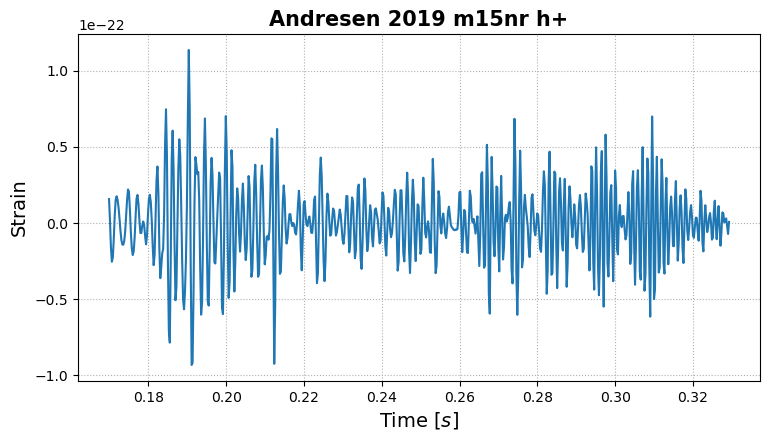

<Figure size 640x480 with 0 Axes>

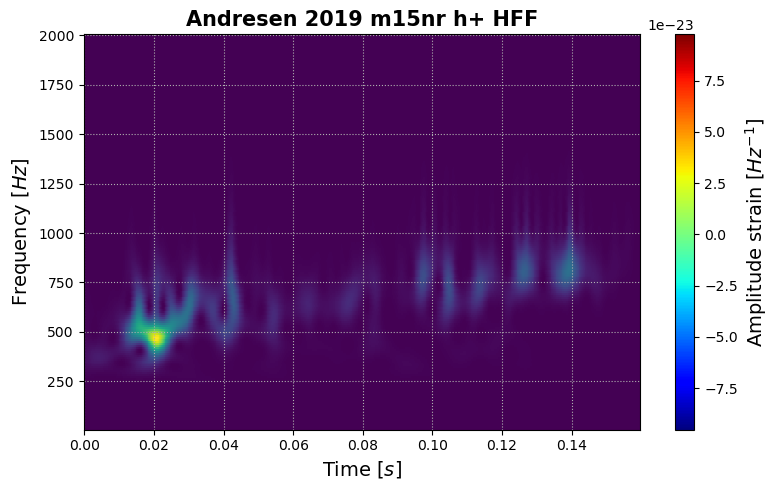

2276

<Figure size 640x480 with 0 Axes>

In [42]:
# ------> Rescale waveform to the given distance

s_hp_resc = rescale_gw(s_hp, set_distance)

# ------> Apply a high-pass filter to remove SASI feature

ts = t[1]-t[0]
fs = 1/ts
s_hp_filt = filt_highpass_NumWF(s_hp_resc, fs, 8, 250, 0)

# ------> Strain removal for early times to align HFF

#  Remark: We apply this removal to align HFF start at the beginning of the Num. waveform
#          in consistency with the HFF observed in TF scalograms for Phen. waveforms.
#          For now, we set this by visual exploration on the scalogram, leaving to future
#          works the general estimation of the HFF's initial time.

###################
t_lim = 0.16
###################

t_out = t[round(t_lim/ts):]
s_hp_filt_out = s_hp_filt[round(t_lim/ts):]

# ------> Compute waveform duration

wf_duration = t[-1] - t[0]
wf_duration_out = round(t_out[-1] - t_out[0], 10)

print("======> WF duration (in seconds) BEFORE modification:", wf_duration)
print("======> WF duration (in seconds) AFTER modification:", wf_duration_out)
print("")

# ------> Check plots of the modified waveform

# Waveform strain 

plt.figure(1, figsize=(8.8,4.5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t_out, s_hp_filt_out)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

# TF wavelet scalogram

#time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 20, 1000, 20, 7, 0)
time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 10, 2000, 10, 7, 0)

plt.figure(2, figsize=(8,5))

plt.title(model_name + " HFF", fontsize=15, fontweight="bold")

plt.pcolormesh(time, freq, WL, shading='auto')
norm = colors.Normalize(s_hp.min(), s_hp.max())
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)
plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Andresen_scalogram_HFF.pdf", format="pdf")
plt.show()
plt.figure(2).clear()
gc.collect()

### 1.7. Save modified waveforms

In [45]:
# ------> Set strings for file name

model = model_name.replace(" ", "_")
slope = str(round(res.slope))
label = str(model_class)
wf_du = str(wf_duration)

# ------> Save resampled and rescaled waveform

if not os.path.exists('../Waveforms_mod/GenRel'): 
    os.makedirs('../Waveforms_mod/GenRel')

df_wf = pd.DataFrame({"time" : t_out, "strain" : s_hp_filt_out})
df_wf.to_csv("../Waveforms_mod/GenRel/" + model + "_D_" + str(set_distance) + "Kpc" + "_dur_" + wf_du + "s" + "_HFFslope_" + slope + "_class_" + label + ".txt", index=False)

## 2. Morozova 2018 2D models

### 2.1. Read files

In [49]:
# ------> Remarks

# Paper available on: https://doi.org/10.3847/1538-4357/aac5f1
# Waveforms available on: https://www.astro.princeton.edu/~burrows/gw/

# ------> Set model's name

model_name = "Morozova 2018 M13_SFHo h+"

# ------> Read files

# Read dat file
file_path = wf_num_dir + "Morozova 2018/" + "gwstrain_M13_SFHo.dat"
wf_model = pd.read_csv(file_path, delim_whitespace=True, skiprows=1, header=None)

# Name columns
wf_model.columns = ['Time (s)', 'h+ (cm)']

# Check: Print dataframe
print("Morozova 2018 M13_SFHo h+ model")
print("----------------------------------")
print(wf_model.head())

Morozova 2018 M13_SFHo h+ model
----------------------------------
   Time (s)   h+ (cm)
0 -0.246447  0.000122
1 -0.246398  0.000122
2 -0.246345  0.000122
3 -0.246291  0.000122
4 -0.246245  0.000122


### 2.2. Resample waveform

In [52]:
# ------> Create numpy arrays

waveform = wf_model.to_numpy()
wf_model = np.transpose(waveform)

# ------> Resampling to fs = fs_after

t, s_hp = resample_gw(wf_model[0], wf_model[1], fs_after)

### 2.3. Rescale waveform

In [54]:
# ------> Convert strains to adimensional at 10 Kpc 

s_hp = s_hp * D10kpc

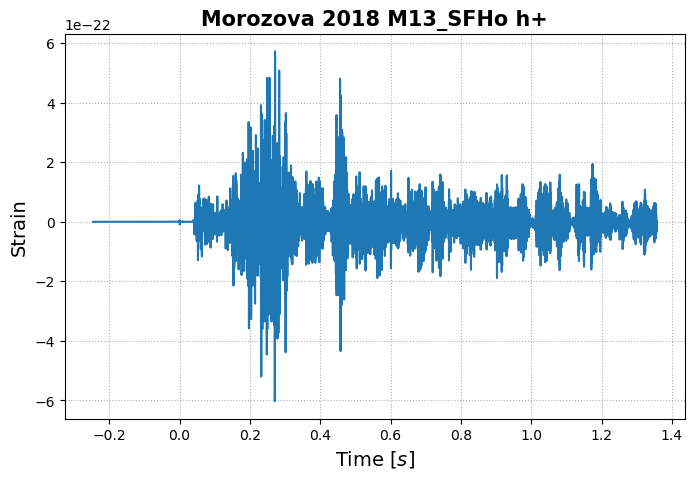

4284

<Figure size 640x480 with 0 Axes>

In [55]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t, s_hp)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

#plt.savefig("../Figures/" + "Morozova_strain.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

In [56]:
# ------> Set some distances to check strain plots

s_hp_5  = rescale_gw(s_hp, 5)
s_hp_20 = rescale_gw(s_hp, 20)
s_hp_40 = rescale_gw(s_hp, 40)

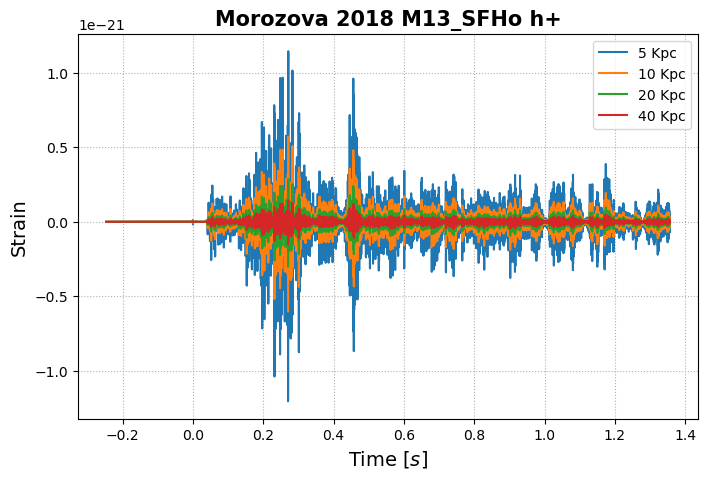

4755

<Figure size 640x480 with 0 Axes>

In [57]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

plt.plot(t, s_hp_5, label="5 Kpc")
plt.plot(t, s_hp, label="10 Kpc")
plt.plot(t, s_hp_20, label="20 Kpc")
plt.plot(t, s_hp_40, label="40 Kpc")
plt.legend()

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

### 2.4. Generate scalogram

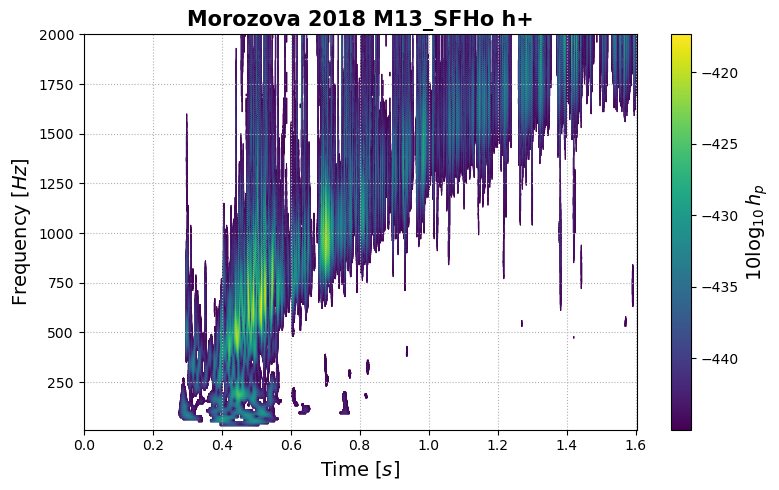

7945

<Figure size 640x480 with 0 Axes>

In [59]:
# ------> Compute wavelet transform

#time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 2000, 20, 7, 0) # Only for printable plot
time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 2000, 10, 7, 0)

# ------> Plot scalogram

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

# ------- LOG_10 SCALE

log_WL = 10 * np.log10(WL)

# Set threshold for pixels
############################################
threshold = -445
############################################

# Apply the threshold to the spectrogram data
log_WL_thr = np.where(log_WL > threshold, log_WL, np.nan)

plt.pcolormesh(time, freq, log_WL_thr, shading='gouraud')
plt.colorbar().set_label(label="$10\log_{10} h_p$", size=14)

# ------- LINEAR SCALE

#plt.pcolormesh(time, freq, WL, shading='gouraud')

#norm = colors.Normalize(s_hp.min(), s_hp.max())
#mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

#plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

# -------------------------

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Morozova_scalogram.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

### 2.5. HFF slope estimation

Wavelet Matrix dim: (200, 6566)
Time array dim: (6566,)
Frequency array dim: (200,)

Delta t =  0.000244140625
Delta f =  10.0

Aritmetic mean of WL pixels: 9.531472952361358e-45

Sorted t array length: 182326
Sorted f array length: 182326
Sorted W array length: 182326



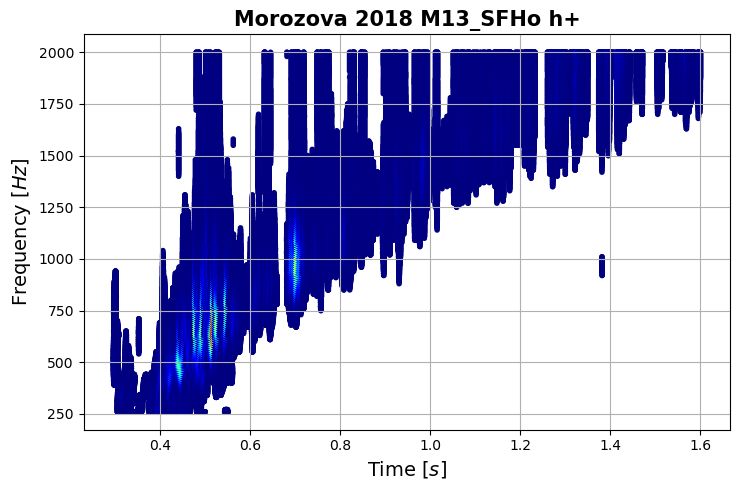

In [67]:
# ------> Plot pixelized (scattered) scalogram

# Check dimensions
print("Wavelet Matrix dim:", WL.shape)
print("Time array dim:", time.shape)
print("Frequency array dim:", np.transpose(freq)[0].shape)

print("")

# Sampling time / frequency
delta_t = time[1] - time[0]
delta_f = freq[1][0] - freq[0][0]
print("Delta t = ", delta_t)
print("Delta f = ", delta_f)

print("")

# Mean of WL pixels
WL_mean = np.mean(WL)
print("Aritmetic mean of WL pixels:", WL_mean)

# Reorganize arrays for time, freq, and wavelet

sorted_t = []
sorted_f = []
sorted_W = []

# Remark: WL[freq_index][time_index] (elements)
#         freq_index for row, time_index is for column

for freq_index in range(WL.shape[0]):    
    for time_index in range(WL.shape[1]):
        
        # Selection 1: Most energetic pixels,
        #              WL > mean(WL)
        if WL[freq_index][time_index] > WL_mean:
            
            # Selection 2: Pixels non in convection feature
            #              t > 0.1 seconds
            if time_index*delta_t > 0.1:
            
            # Selection 3: Pixels non in SASI feature,
            #              f > 250 Hz
                if (freq_index+1)*delta_f > 250:
                
                    sorted_t.append(time[time_index])
                    sorted_f.append(freq[freq_index])
                    sorted_W.append(WL[freq_index][time_index])

print("")
            
# Check dimensions
print("Sorted t array length:", len(sorted_t))
print("Sorted f array length:", len(sorted_f))
print("Sorted W array length:", len(sorted_W))

print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)
    
plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")

#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()
plt.show()

Linear regression for most energetic pixels
---------------------------------------------
R-squared: 0.9396038669594995
Intercept: -58.93807416176287
Slope: 1451.369811867278
---------------------------------------------



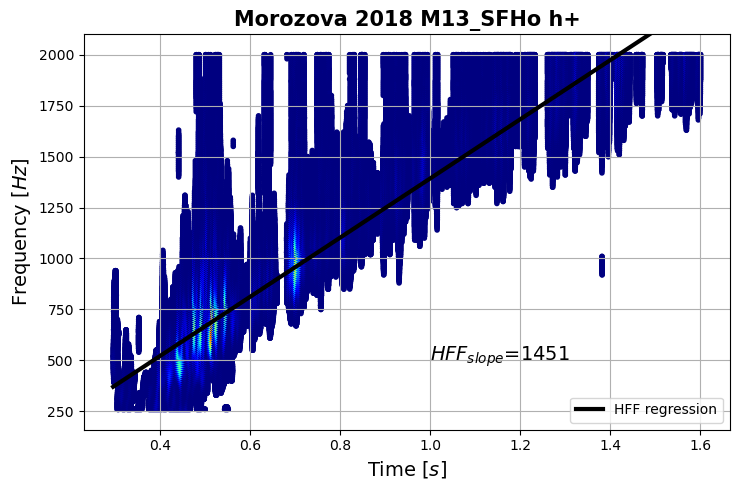

<Figure size 640x480 with 0 Axes>

In [68]:
# ------> Linear regression to estimate HFF slope

# Unique values of time
unique_t = np.unique(sorted_t)

# Initialize array for location of
# most energetic pixels per time
locate_maxpix = []

# Select most energetic pixels per time
for i in range(len(unique_t)):
    
    # Find location indexes for unique_t(i) in sorted_t array
    time_loc_ind = np.where(sorted_t == unique_t[i])[0]

    # Select most energetic pixel at time unique_t(i)
    W_max = 0
    for j in range(len(time_loc_ind)):
        
        if sorted_W[time_loc_ind[j]] > W_max:
            W_max = sorted_W[time_loc_ind[j]]
            ind_max_onetime = time_loc_ind[j]
    
    locate_maxpix.append(ind_max_onetime)

# Location (time,freq) of most energetic pixels
t_lr = np.take(sorted_t, locate_maxpix)
f_lr = np.take(sorted_f, locate_maxpix)

# Apply linear regression
res = stats.linregress(t_lr, f_lr)

# Print results
print("Linear regression for most energetic pixels")
print("---------------------------------------------")
print("R-squared:", res.rvalue**2)
print("Intercept:", res.intercept)
print("Slope:", res.slope)
print("---------------------------------------------")
print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)
plt.plot(t_lr, res.intercept + res.slope*t_lr, 'k-', linewidth=3, label='HFF regression')
plt.text(1.0, 500,'$HFF_{slope}$='+str(round(res.slope)), fontsize=14)

plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")
plt.ylim(top=2100)
plt.legend()

#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()

#plt.savefig("../Figures/" + "Morozova_HFFslope.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

plt.show()

In [69]:
# ------> Compute the class of the waveform

model_class = check_class_HFFslope(res.slope)

Waveform is in class 2
+++++++++++++++++++++++++++


### 2.6. Modify waveform

****** Butterworth filter's coefficients  ******

Input: [  0.371292    -2.97033601  10.39617602 -20.79235204  25.99044006
 -20.79235204  10.39617602  -2.97033601   0.371292  ]
Output: [  1.          -6.0355128   16.12804997 -24.88768569  24.23088494
 -15.22839995   6.02867932  -1.37368178   0.13785775]

======> WF duration (in seconds) BEFORE modification: 1.602783203125
======> WF duration (in seconds) AFTER modification: 1.302734375



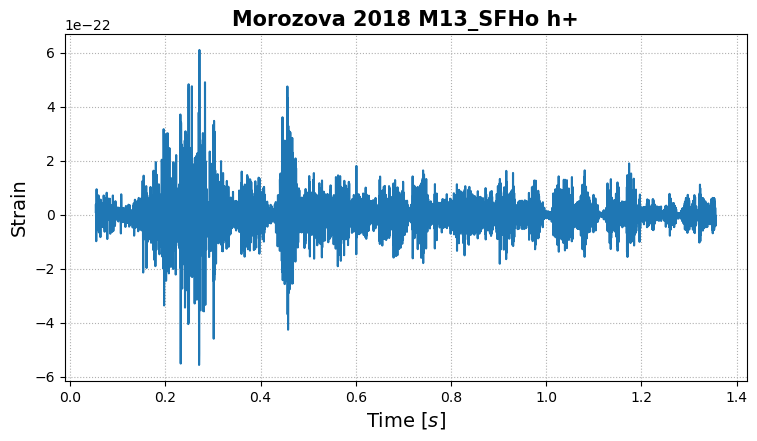

<Figure size 640x480 with 0 Axes>

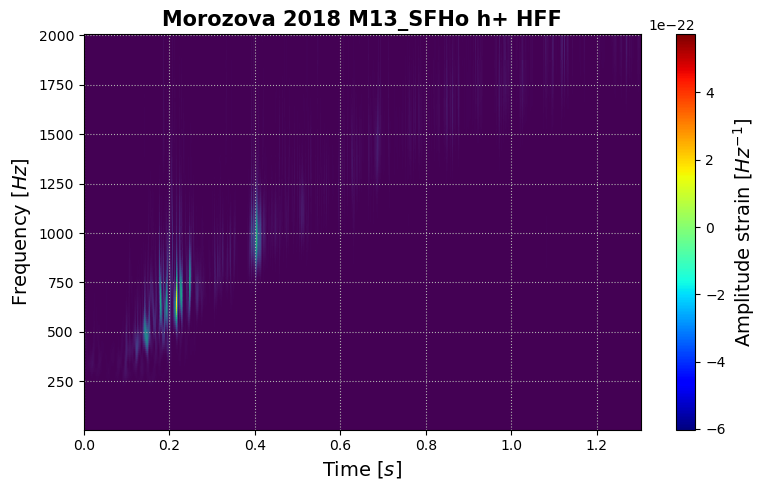

7713

<Figure size 640x480 with 0 Axes>

In [74]:
# ------> Rescale waveform to the given distance

s_hp_resc = rescale_gw(s_hp, set_distance)

# ------> Apply a high-pass filter to remove SASI feature

ts = t[1]-t[0]
fs = 1/ts
s_hp_filt = filt_highpass_NumWF(s_hp_resc, fs, 8, 250, 0)

# ------> Strain removal for early times to align HFF

#  Remark: We apply this removal to align HFF start at the beginning of the Num. waveform
#          in consistency with the HFF observed in TF scalograms for Phen. waveforms.
#          For now, we set this by visual exploration on the scalogram, leaving to future
#          works the general estimation of the HFF's initial time.

###################
t_lim = 0.3
###################

t_out = t[round(t_lim/ts):]
s_hp_filt_out = s_hp_filt[round(t_lim/ts):]

# ------> Compute waveform duration

wf_duration = t[-1] - t[0]
wf_duration_out = round(t_out[-1] - t_out[0], 10)

print("======> WF duration (in seconds) BEFORE modification:", wf_duration)
print("======> WF duration (in seconds) AFTER modification:", wf_duration_out)
print("")

# ------> Check plots of the modified waveform

# Waveform strain 

plt.figure(1, figsize=(8.8,4.5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t_out, s_hp_filt_out)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

# TF wavelet scalogram

#time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 20, 1000, 20, 7, 0)
time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 10, 2000, 10, 7, 0)

plt.figure(2, figsize=(8,5))

plt.title(model_name + " HFF", fontsize=15, fontweight="bold")

plt.pcolormesh(time, freq, WL, shading='auto')
norm = colors.Normalize(s_hp.min(), s_hp.max())
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)
plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Morozova_scalogram_HFF.pdf", format="pdf")
plt.show()
plt.figure(2).clear()
gc.collect()

### 2.7. Save modified waveforms

In [76]:
# ------> Set strings for file name

model = model_name.replace(" ", "_")
slope = str(round(res.slope))
label = str(model_class)
wf_du = str(wf_duration)

# ------> Save resampled and rescaled waveform

if not os.path.exists('../Waveforms_mod/GenRel'): 
    os.makedirs('../Waveforms_mod/GenRel')

df_wf = pd.DataFrame({"time" : t_out, "strain" : s_hp_filt_out})
df_wf.to_csv("../Waveforms_mod/GenRel/" + model + "_D_" + str(set_distance) + "Kpc" + "_dur_" + wf_du + "s" + "_HFFslope_" + slope + "_class_" + label + ".txt", index=False)

## 3. Cerda-Duran 2013 2D models

### 3.1. Read files

In [79]:
# ------> Remarks

# Paper available on: https://iopscience.iop.org/article/10.1088/2041-8205/779/2/L18
# Waveforms available on: https://www.uv.es/cerdupa/COCONUT/GWDATA/

# ------> Set model's name

model_name = "Cerda-Duran 2013 fiducial h+"

# ------> Read files

# Read dat file
file_path = wf_num_dir + "Cerda-Duran 2013/" + "hplus_35OC_fiducial_100kpc.dat"
wf_model = pd.read_csv(file_path, delim_whitespace=True, skiprows=3, header=None)

# Name columns
wf_model.columns =['Time (s)', 'h+ (cm)']

# Check: Print dataframe
print(model_name + " model")
print("---------------------------")
print(wf_model.head())
print("")

Cerda-Duran 2013 fiducial h+ model
---------------------------
   Time (s)       h+ (cm)
0  0.000000  0.000000e+00
1  0.000442 -8.331592e-23
2  0.000886 -5.967001e-23
3  0.001330 -5.967033e-23
4  0.001774 -5.967021e-23



### 3.2. Resample waveform

In [81]:
# ------> Create numpy arrays

waveform = wf_model.to_numpy()
wf_model = np.transpose(waveform)

# ------> Resampling to fs = fs_after

t, s_hp = resample_gw(wf_model[0], wf_model[1], fs_after)

In [82]:
# ------> Remove waveform's right edge

# Remark: For this waveform, we apply this procedure to focus
#         the analysis to the region in which HFF is predominant

t, s_hp = remove_gw_edges(t, s_hp, t[0], 1.6)
#t, s_hp = remove_gw_edges(t, s_hp, t[0], 0.85)
#t, s_hp = remove_gw_edges(t, s_hp, t[0], 1.1)
#t, s_hp = remove_gw_edges(t, s_hp, t[0], 1.3)
#t, s_hp = remove_gw_edges(t, s_hp, t[0], t[-1])

First sample of cropped arrays = 0
Last sample of cropped arrays = 6553


### 3.3. Rescale waveform

In [86]:
# ------> Convert strains at 10 Kpc 

s_hp = s_hp * 10

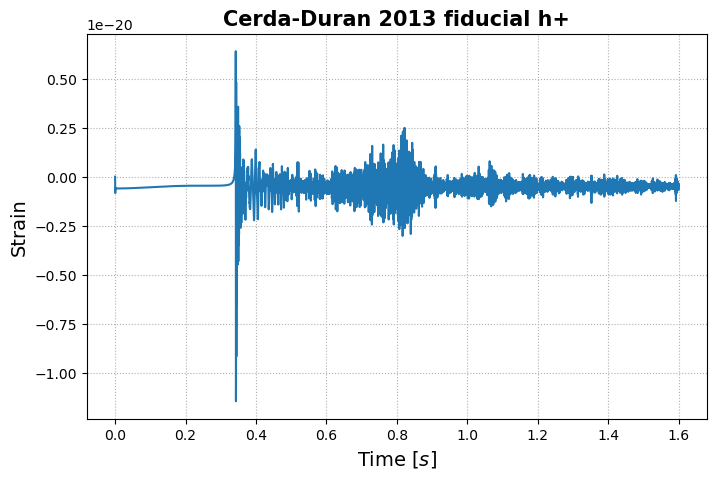

4405

<Figure size 640x480 with 0 Axes>

In [87]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t, s_hp)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

#plt.savefig("../Figures/" + "Cerda-Duran_strain.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

In [88]:
# ------> Set some distances to check strain plots

s_hp_5  = rescale_gw(s_hp, 5)
s_hp_20 = rescale_gw(s_hp, 20)
s_hp_40 = rescale_gw(s_hp, 40)

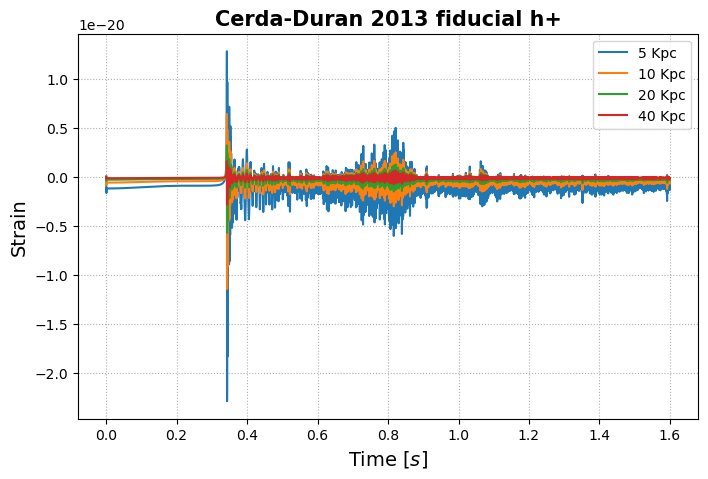

5056

<Figure size 640x480 with 0 Axes>

In [89]:
# ------> Check plot

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

plt.plot(t, s_hp_5, label="5 Kpc")
plt.plot(t, s_hp, label="10 Kpc")
plt.plot(t, s_hp_20, label="20 Kpc")
plt.plot(t, s_hp_40, label="40 Kpc")
plt.legend()

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

### 3.4. Generate scalogram

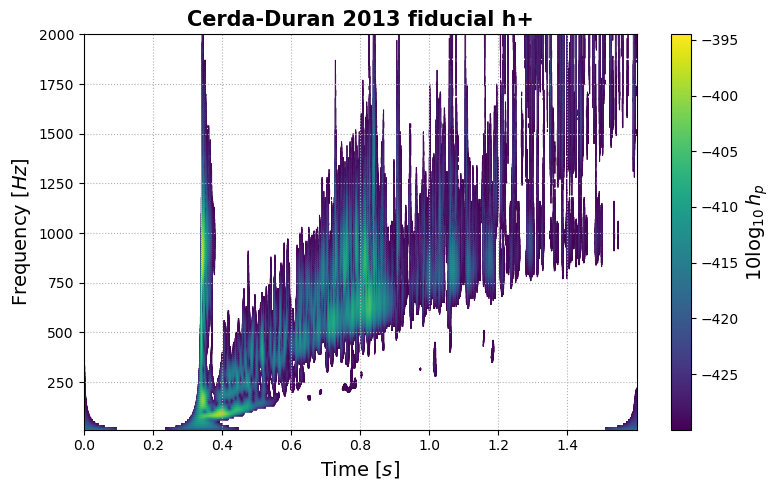

7983

<Figure size 640x480 with 0 Axes>

In [91]:
# ------> Plot scalogram

# ------> Compute wavelet transform

#time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 1000, 10, 7, 0) # Only for printable plot
time, freq, WL = WaveletTF_transform(s_hp, fs_after, 10, 2000, 10, 7, 0)

plt.figure(1, figsize=(8,5))

plt.title(model_name, fontsize=15, fontweight="bold")

# ------- LOG_10 SCALE

log_WL = 10 * np.log10(WL)

# Set threshold for pixels
############################################
threshold = -430
############################################

# Apply the threshold to the spectrogram data
log_WL_thr = np.where(log_WL > threshold, log_WL, np.nan)

plt.pcolormesh(time, freq, log_WL_thr, shading='gouraud')
plt.colorbar().set_label(label="$10\log_{10} h_p$", size=14)

# ------- LINEAR SCALE

#plt.pcolormesh(time, freq, WL, shading='gouraud')

#norm = colors.Normalize(s_hp.min(), s_hp.max())
#mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

#plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

# -------------------------

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Cerda-Duran_scalogram.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

### 3.5. HFF slope estimation

Wavelet Matrix dim: (200, 6554)
Time array dim: (6554,)
Frequency array dim: (200,)

Delta t =  0.000244140625
Delta f =  10.0

Aritmetic mean of WL pixels: 5.795179026521487e-43

Sorted t array length: 90507
Sorted f array length: 90507
Sorted W array length: 90507



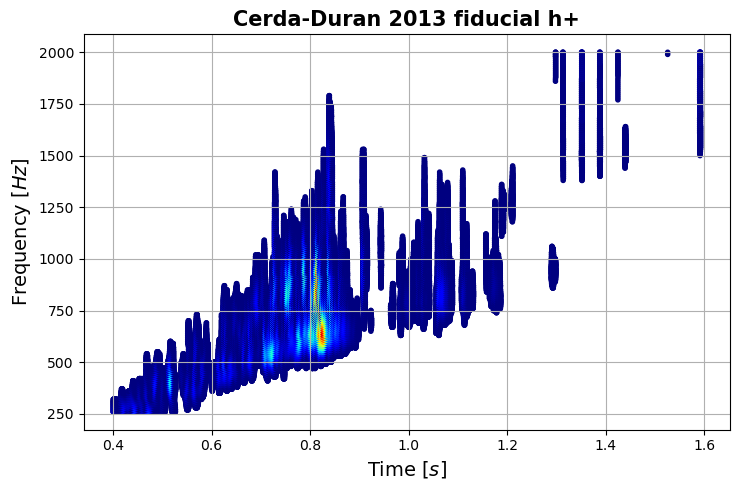

In [93]:
# ------> Plot pixelized (scattered) scalogram

# Check dimensions
print("Wavelet Matrix dim:", WL.shape)
print("Time array dim:", time.shape)
print("Frequency array dim:", np.transpose(freq)[0].shape)

print("")

# Sampling time / frequency
delta_t = time[1] - time[0]
delta_f = freq[1][0] - freq[0][0]
print("Delta t = ", delta_t)
print("Delta f = ", delta_f)

print("")

# Mean of WL pixels
WL_mean = np.mean(WL)
print("Aritmetic mean of WL pixels:", WL_mean)

# Reorganize arrays for time, freq, and wavelet

sorted_t = []
sorted_f = []
sorted_W = []

# Remark: WL[freq_index][time_index] (elements)
#         freq_index for row, time_index is for column

for freq_index in range(WL.shape[0]):    
    for time_index in range(WL.shape[1]):
        
        # Selection 1: Most energetic pixels,
        #              WL > mean(WL)
        if WL[freq_index][time_index] > WL_mean:
            
            # Selection 2: Pixels non in convection feature
            #              t > 0.4 seconds
            if time_index*delta_t > 0.4:
            
            # Selection 3: Pixels non in SASI feature,
            #              f > 250 Hz
                if (freq_index+1)*delta_f > 250:
                
                    sorted_t.append(time[time_index])
                    sorted_f.append(freq[freq_index])
                    sorted_W.append(WL[freq_index][time_index])

print("")
            
# Check dimensions
print("Sorted t array length:", len(sorted_t))
print("Sorted f array length:", len(sorted_f))
print("Sorted W array length:", len(sorted_W))

print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)
    
plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")

#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()
plt.show()

Linear regression for most energetic pixels
---------------------------------------------
R-squared: 0.774443338178946
Intercept: -112.19995768189449
Slope: 956.2609895612195
---------------------------------------------



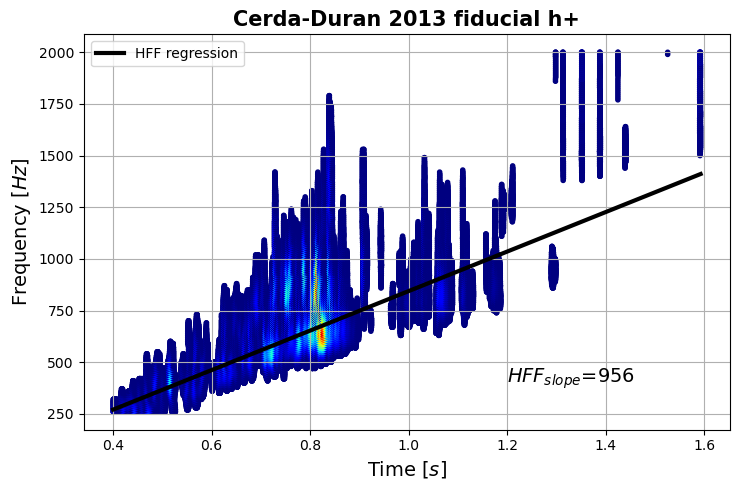

<Figure size 640x480 with 0 Axes>

In [94]:
# ------> Linear regression to estimate HFF slope

# Unique values of time
unique_t = np.unique(sorted_t)

# Initialize array for location of
# most energetic pixels per time
locate_maxpix = []

# Select most energetic pixels per time
for i in range(len(unique_t)):
    
    # Find location indexes for unique_t(i) in sorted_t array
    time_loc_ind = np.where(sorted_t == unique_t[i])[0]

    # Select most energetic pixel at time unique_t(i)
    W_max = 0
    for j in range(len(time_loc_ind)):
        
        if sorted_W[time_loc_ind[j]] > W_max:
            W_max = sorted_W[time_loc_ind[j]]
            ind_max_onetime = time_loc_ind[j]
    
    locate_maxpix.append(ind_max_onetime)

# Location (time,freq) of most energetic pixels
t_lr = np.take(sorted_t, locate_maxpix)
f_lr = np.take(sorted_f, locate_maxpix)

# Apply linear regression
res = stats.linregress(t_lr, f_lr)

# Print results
print("Linear regression for most energetic pixels")
print("---------------------------------------------")
print("R-squared:", res.rvalue**2)
print("Intercept:", res.intercept)
print("Slope:", res.slope)
print("---------------------------------------------")
print("")

# Plot scattered scalogram for most energetic pixels

fig = plt.figure(figsize=(7.5,5))
sc = plt.scatter(sorted_t, sorted_f, c=sorted_W, marker='.', cmap=plt.cm.jet)
plt.plot(t_lr, res.intercept + res.slope*t_lr, 'k-', linewidth=3, label='HFF regression')
plt.text(1.2, 400,'$HFF_{slope}$='+str(round(res.slope)), fontsize=14)

plt.xlabel("Time [$s$]", fontsize=14)
plt.ylabel("Frequency [$Hz$]", fontsize=14)
plt.title(model_name, fontsize=15, fontweight="bold")
plt.legend()

#plt.colorbar(sc)
plt.grid(True)
plt.tight_layout()

#plt.savefig("../Figures/" + "Cerda-Duran_HFFslope.pdf", format="pdf")

plt.show()
plt.figure(1).clear()
gc.collect()

plt.show()

In [95]:
# ------> Compute the class of the waveform

model_class = check_class_HFFslope(res.slope)

Waveform is in class 3
+++++++++++++++++++++++++++


### 3.6. Modify waveform

****** Butterworth filter's coefficients  ******

Input: [  0.371292    -2.97033601  10.39617602 -20.79235204  25.99044006
 -20.79235204  10.39617602  -2.97033601   0.371292  ]
Output: [  1.          -6.0355128   16.12804997 -24.88768569  24.23088494
 -15.22839995   6.02867932  -1.37368178   0.13785775]

======> WF duration (in seconds) BEFORE modification: 1.599853515625
======> WF duration (in seconds) AFTER modification: 1.2199707031



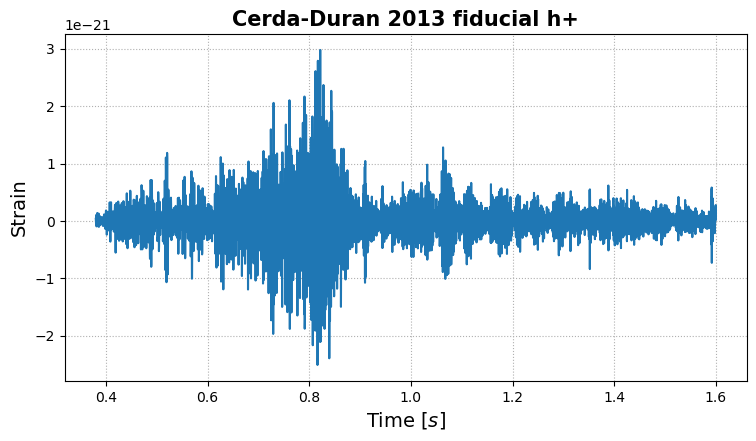

<Figure size 640x480 with 0 Axes>

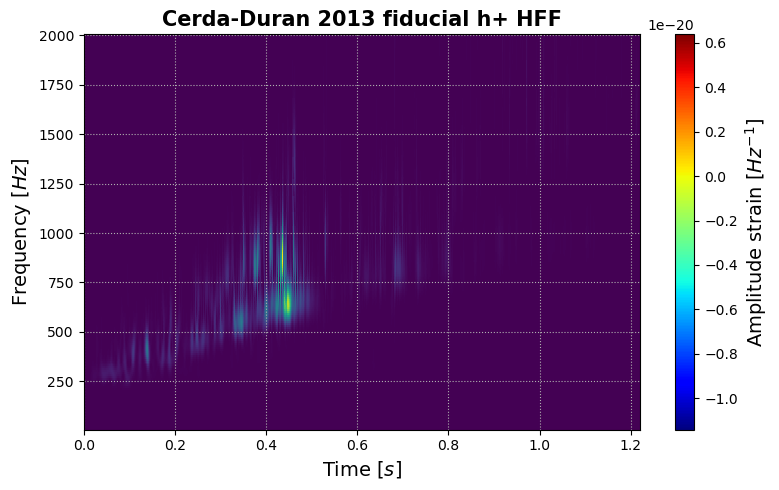

7631

<Figure size 640x480 with 0 Axes>

In [97]:
# ------> Rescale waveform to the given distance

s_hp_resc = rescale_gw(s_hp, set_distance)

# ------> Apply a high-pass filter to remove SASI feature

ts = t[1]-t[0]
fs = 1/ts
s_hp_filt = filt_highpass_NumWF(s_hp_resc, fs, 8, 250, 0)

# ------> Strain removal for early times to align HFF

#  Remark: We apply this removal to align HFF start at the beginning of the Num. waveform
#          in consistency with the HFF observed in TF scalograms for Phen. waveforms.
#          For now, we set this by visual exploration on the scalogram, leaving to future
#          works the general estimation of the HFF's initial time.

###################
t_lim = 0.38
###################

t_out = t[round(t_lim/ts):]
s_hp_filt_out = s_hp_filt[round(t_lim/ts):]

# ------> Compute waveform duration

wf_duration = t[-1] - t[0]
wf_duration_out = round(t_out[-1] - t_out[0], 10)

print("======> WF duration (in seconds) BEFORE modification:", wf_duration)
print("======> WF duration (in seconds) AFTER modification:", wf_duration_out)
print("")

# ------> Check plots of the modified waveform

# Waveform strain 

plt.figure(1, figsize=(8.8,4.5))

plt.title(model_name, fontsize=15, fontweight="bold")
plt.plot(t_out, s_hp_filt_out)
plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.grid(which='both', linestyle=':')

plt.show()
plt.figure(1).clear()
gc.collect()

# TF wavelet scalogram

#time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 20, 1000, 20, 7, 0)
time, freq, WL = WaveletTF_transform(s_hp_filt_out, fs_after, 10, 2000, 10, 7, 0)

plt.figure(2, figsize=(8,5))

plt.title(model_name + " HFF", fontsize=15, fontweight="bold")

plt.pcolormesh(time, freq, WL, shading='auto')
norm = colors.Normalize(s_hp.min(), s_hp.max())
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)
plt.colorbar(mappable, ax=plt.gca()).set_label(label="Amplitude strain [$Hz^{-1}$]", size=14)

plt.xlabel('Time [$s$]', fontsize=14)
plt.ylabel('Frequency [$Hz$]', fontsize=14)

plt.grid(which='both', linestyle=':')
plt.tight_layout()

#plt.savefig("../Figures/" + "Cerda-Duran_scalogram_HFF.pdf", format="pdf")
plt.show()
plt.figure(2).clear()
gc.collect()

### 3.7. Save modified waveforms

In [99]:
# ------> Set strings for file name

model = model_name.replace(" ", "_")
slope = str(round(res.slope))
label = str(model_class)
wf_du = str(wf_duration)

# ------> Save resampled and rescaled waveform

if not os.path.exists('../Waveforms_mod/GenRel'): 
    os.makedirs('../Waveforms_mod/GenRel')

df_wf = pd.DataFrame({"time" : t_out, "strain" : s_hp_filt_out})
df_wf.to_csv("../Waveforms_mod/GenRel/" + model + "_D_" + str(set_distance) + "Kpc" + "_dur_" + wf_du + "s" + "_HFFslope_" + slope + "_class_" + label + ".txt", index=False)